# Learning the Impact of Campaign Spending



Team: Cluster One - Landon Buechner

3/31/2021

<br/>

----
<br/>


**Abstract**

In this work, I investigate to what degree campaign spending influences state level election outcomes in the 2016 presidential election between Hillary Clinton and Donald Trump using a hierarchical binomial-logit regression model with a Gaussian mixture prior on the random effects. 

<br/>

**Data**

I use the total amount of money spent over the course of the election by both Democratic (DEM) and Republican (REP) campains in 7 unique expense categories, leading to 14 financial predictors. These are augmented by 10 additional demographic features for each state $i \in \mathcal{S}$ where $ \mathcal{S}$ is the index set for all 51 states. These are used to hierarchically model the proportion of DEM voters $\theta_i$ in each state given the observed counts of DEM votes $y_i$ and total turnout $N_i$ using Bayesian inference. Note that the predictor variables are standardized. Letting $\beta_i \in \mathbb{R}^{24}$ we have the following

$$ X_i = ( \text{expenses}, \text{demographics})_i \in \mathbb{R}^{24}$$

$$ \text{logit}(\theta_i) = X_i^T \beta_i$$

$$y_i \sim \text{Binomial}\big(\theta_i  ,  N_i )$$

<br/>

**Add Modelling Summary**

Use fingers to type words

<br/>

**Latent Voter Populations**

In my modelling procedure I intially fit a simple hierarchical binomial-logit regression model with a centered Gaussian prior on the state level regression coeficients. Interestingly this led to a posterior with whith multimodal marginal densities that shared common structure across states and can be interpreted as the existance of multiple sub-populations each with unique political leanings. For example, in any given state the DEM leaning sub-population will have a positive response to democratic advertisements whereas right leaning voters would have a significantly diminshed resulting in a bimodal posterior. It turns out that many of the marginal densities are in fact multimodal which suggest that there are additional groups of voters who too have their own unique response to various campaign investment in their state. 

The simple model with single Gaussian prior is able to reveal this multimodal structure, but not directly model it. The highlight of this work is a hierarchical binomial-logit regression model with a Gaussian mixture prior on the random effects. By changing the prior we are able to decompose the posterior into induvidual component Gaussians each which correspond to a distinct latent voter class. This decomposition is powerful a powerful tool for campaign strategists because it not only identifys, at the state level, what forms of spendending positively shift the vote but what latent subpopulations are responsible for that shift. 

The fundemental question at hand is: "Within each state, how much money should be allocated to each expense category in order to maximize the odds of winning the election?" To answer this question and conclude my research I conduct a simulation study where various asset allocation strategies are compared in an attempt to demonstrate the utility of my model in the real world. 
 
<br/>

**Shortcomings / Limitations**

The main simplification of this model is that it only considers one election at a time. This is a reasonable assumption because the evolution of the political climate over the course of every 4 years between elections is highly dynamic. That being said, there might be something to be learned by jointly modelling campaign expenses/stragy across elections because some states might exhibit consistent behavior over time. 

In [ ]:
!pip install python-dotenv
import os
import json
import string
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from dataclasses import dataclass
from dotenv import load_dotenv

plt.rcParams.update({'font.size': 14})
os.chdir('/content/drive/MyDrive/Data Science/TAMIDS 2021/Competition')
load_dotenv()

from utils import *
from processing import *

Python-dotenv could not parse statement starting at line 1


# Data Processing

In [ ]:
expense_path =  os.environ.get('expense_path')
candidate_path = os.environ.get('candidate_path')
category_path = os.environ.get('category_path')
mapping_path = os.environ.get('mapping_path')
results_path = os.environ.get('results_path')
demographic_path = os.environ.get('demographic_path')

In [ ]:
# loading the mapping used to create the dictionary below (categories)
with open(mapping_path) as f:
  mapping = json.load(f)

# loading in the category mapping data
with open(category_path) as f:
  categories = json.load(f)

mapping_counts = {key: len(value) for key, value in mapping.items()}
category_counts = {key: len(value) for key, value in categories.items()}
total1 = sum([i for i in mapping_counts.values()])
total2 = sum([i for i in category_counts.values()])
print(f"Given a raw dataset with {total2} unique expense types only {category_counts['other']} expenses were \
unclassified ({100*round(category_counts['other']/total2, 4)}%).")

Given a raw dataset with 2515044 unique expense types only 317846 expenses were unclassified (12.64%).


I defined 8 transaction categories and manually went through the FEC Operation expense dataset to identify key words ('PURPOSE' variable) so that I could label/simplify the dataset. These variables serve as predictor variables in the hierarchical model developed below. 

In [ ]:
print("Total key words:", total1)
mapping_counts

Total key words: 315


{'administration': 43,
 'advertising': 40,
 'consulting': 43,
 'events': 68,
 'media': 50,
 'non-expenditure': 25,
 'other': 0,
 'travel': 46}

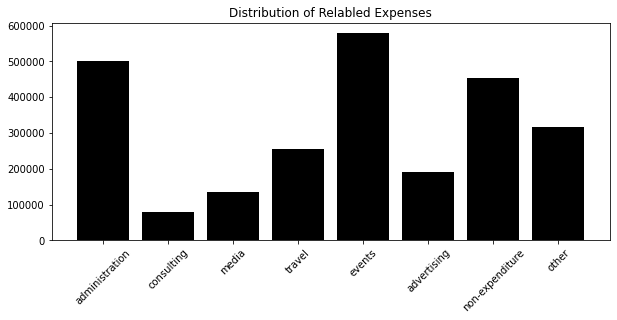

In [ ]:
plt.figure(figsize = (10,4))
plt.bar(list(range(8)), height= [i for i in category_counts.values()], color = 'k')
plt.xticks(list(range(8)),  [i for i in category_counts.keys()], rotation = 45)
plt.title('Distribution of Relabled Expenses')
plt.show()

In [ ]:
# cleaning/loading operation expenses and candidate committee data
data = Dataset(expense_path, candidate_path, categories)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (5,11,14,16,17,19,24) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
# election results 
results = pd.read_csv(results_path).query("party in ['democrat', 'republican']").sort_values(by = ['state_po'])
results = results.groupby(['year', 'state_po', 'candidate'])[['candidatevotes', 'totalvotes']].sum().reset_index()
results['lastname'] = results['candidate'].apply(lambda x: x.split(' ')[-1])
results.head(3)

,year,state_po,candidate,candidatevotes,totalvotes,lastname
0,2000,AK,Al Gore,79004.0,285530,Gore
1,2000,AK,George W. Bush,167398.0,285530,Bush
2,2000,AL,Al Gore,695602.0,1672551,Gore


In [ ]:
# getting (year, candidate) pairs
election_list = results.groupby(['year', 'lastname']).count().index.values
elections = {}
for year, cand in election_list:
  if year not in elections:
    elections[year] = [cand]
  else:
    elections[year].append(cand)
elections = [{'year': key, 'candidates': value} for key,value in elections.items()][3:]
params = elections[-1]
print(params)

{'year': 2016, 'candidates': ['Clinton', 'Trump']}


In [ ]:
# augmenting financial predictors with demographics 
demographics = pd.read_csv(demographic_path)
expenses = get_expenses(data, params)
X = get_covariates(expenses, demographics) # storing to display covariates to user
num_states, num_vars = X.shape

# standardizing
X = (X-X.mean())/X.std()
print(f'{X.shape[0]} states and {X.shape[1]} variables\n\nCovariates X:')
X.head(3)

51 states and 24 variables

Covariates X:


,DEM administration,DEM advertising,DEM consulting,DEM events,DEM media,DEM non-expenditure,DEM travel,REP administration,REP advertising,REP consulting,REP events,REP media,REP non-expenditure,REP travel,average_log_pop_within_5_miles,black_pct,college_pct,hisp_other_pct,median_age,pct_white_evangel,pop_density,pop_total,white_pct,wwc_pct
STATE,,,,,,,,,,,,,,,,,,,,,,,,
AK,-0.168236,-0.147651,-0.402103,-0.192996,-0.400482,-0.170038,-0.297039,-0.224358,-0.21374,-0.614439,-0.639510,-0.478408,-0.301608,-0.362248,-0.923506,-0.739730,-0.447352,1.022013,-1.727401,-0.079657,-0.278217,-0.773299,-0.450168,-0.477843
AL,-0.169202,-0.095724,-0.381720,-0.187772,-0.400482,-0.170201,-0.292454,-0.215521,-0.21374,-0.356828,-0.526189,-0.418276,-0.224125,-0.357785,-0.881205,1.444832,-0.905888,-0.843947,0.238511,1.586981,-0.210551,-0.200914,-0.178956,0.146496
AR,-0.166139,-0.147662,-0.334160,6.950017,-0.388596,-0.169912,-0.253917,-0.223641,-0.21374,-0.543377,-0.461226,-0.385026,-0.294361,-0.362238,-1.111365,0.411059,-1.316790,-0.577144,-0.089141,1.823257,-0.238431,-0.461596,0.258624,0.681770


In [ ]:
import pymc3 as pm 
from scipy.special import expit #inverse logistic function

**Note:** Refer to the write up for a more in depth discussion of the hierarchical model and model diagnostics. The remaining cells contain both my main model development as well as additional experimentation with more complex models.

<br />

**Parameter Descriptions**
  - $\beta_i$ - Covariates for state $i$
  - $\beta^{\mu}$ - Normal prior (Used differently between Model 1 and 2)
  - $\mu$ - Fixed mean for mixture components (Model 2)
  - $w$ - Dirichlet prior over Mixture weightings
  

**Fixed Variables**
  - $\boldsymbol{1}_K \in \mathbb{R}^K$ - One vector
  - $\Sigma \in \mathbb{R}^{24 \times 24}$ - Precomputed correlation matrix of the predictors
  - $\mathbb{I} \in \mathbb{R}^{24 \times 24}$ - Diagonal covariance matrix 

**Motivation for selected scale factors**
  - $\lambda_1 = 50$
    - In light of the hierarchical nature of the model it makes sense to have the most uncertainty at the lowest level, namely the prior on the Gaussian mixture components. 
  -  $\lambda_2 = 25$ 
    - For the distribution of the state level effects, the main parameter of interest and at the top of the hierarchy. I slightly decrease the multiplier to further refine the parameter space. 
    - I also reuse this parameter for the offsets. Since the mixture components are sampled from the aforementioned distribution, I slightly decrease the injected variance into the covariance of the parameter offsets (avoiding "The Funnel of Hell!") so that they have sufficient wiggle room within the support of the root distributions.

# Bayesian Hierarchical Models

I fit two models because when I was developing these models I started with the more simple one and made changed based on the results of inference. Note that the notation for the distribution of the offsets is suprsessed for readability. To see the full model structure refer to the pymc3 implimentations below.

**Model 1:**
---

Estimating heirarchical model with regularizing prior. 

$$y_i \sim \text{Binomial}\big(\theta_i  ,  N_i )$$

$$ \text{logit}(\theta_i) = X_i^T \beta_i$$

$$\beta_i \sim \mathcal{N}(\,\beta^{\mu} , \, \lambda_2\Sigma\,)$$
  
$$\beta^{\mu} \sim  \mathcal{N}(\, 0 \,, \, \lambda_1 \mathbb{I}\,)$$

Posterior density for the hierarchical binomial-logit regression model with a centered gaussian prior

$$ \pi(\,\beta \, | \, X, \, Y) \propto \prod_{i=1}^{51} \text{Binomial}\big(\, y_i \, | \, \theta_i, \,N_i \,\big) \, \mathcal{N}(\, \beta_i  \, | \, \lambda_2 \Sigma \,) \, \mathcal{N}(\, \beta^{\mu} \, | \, \lambda_1 \mathbb{I}\,)$$

**Model 2**
---

I use the posterior mean of the state level coefficients $\mu$ from the first model as the hyperprior mean for the guassian mixtures in the second model. With regards to sampling, this is effectively a 'warm start'. 

$$y_i \sim \text{Binomial}\big(\theta_i  ,  N_i )$$

$$ \text{logit}(\theta_i) = X_i^T \beta_i$$

$$\beta_i \sim \sum_{h=1}^K w_h \, \mathcal{N}_h(\,\beta^{\mu}  , \, \lambda_2  \Sigma\,)$$ 

$$w \sim \text{Dirichlet}(\,\boldsymbol{1}_K\,)$$ 

$$\beta^{\mu} \sim \mathcal{N}(\, \mu , \,\lambda_1 \mathbb{I} \,)$$

<br />

Posterior density for the hierarchical binomial-logit regression model with a mixture random effects prior

<br />

$$ \pi(\, \beta, \, w \, | \, X, \, Y) \propto \prod_{i=1}^{51} \text{Binomial}\big(\, y_i \, | \, \theta_i, \,N_i \,\big) \, \mathcal{N}(\, \beta_i \, | \, \lambda_2 \Sigma \,) \bigg[\sum_{h=1}^{K}w_h \, \mathcal{N}_h(\, \beta^{\mu}  \, | \, \lambda_1 \mathbb{I} \,)\bigg]\pi(w)$$

In [ ]:
#Loading in observations to use in the Binomial likelihood
year = params['year']
res = results.query("year == @year & lastname == 'Clinton'")
y = res['candidatevotes']
N = res['totalvotes']

# stablizing the correlation matrix by making it diagonally dominant, helps with singularities 
corr_matr = X.corr() + 5*np.eye(num_vars) #
corr_matr[abs(corr_matr) < 0] = 0

**Reparameterization Trick**

An important adjustment to both models hierarchical structure is made in order to allow for better convergence. By adding an intermediate prior that models the shift of the $\beta_i$ from the prior we can combat the so called "Funnel of Hell". Without the reparameterization discussed in the link below, effective sampling of the posterior would be infeasable.

[Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)

# Model 1

In [ ]:
# injecting uncertainty into the covariance
Lambda1 = 50 
Lambda2 = 25 

# Specifying Hierarchical Model and performing MCMC
with pm.Model() as Induv_Model:
  beta_mu = pm.MvNormal('beta_mu', mu = np.zeros(num_vars), cov = Lambda1*np.eye(num_vars), shape = (num_vars,))
  beta_offset = pm.MvNormal('offset', mu = np.zeros(num_vars), cov = Lambda2*np.eye(num_vars), shape = (num_vars,))
  beta = pm.MvNormal('beta', mu = beta_mu+beta_offset, cov = Lambda2*corr_matr, shape = (num_states, num_vars))
  thetas = pm.math.invlogit(pm.math.sum(X.values*beta, axis = 1))
  likelihood = pm.Binomial("likelihood", observed = y, n = N, p = thetas)
  Induv_Trace = pm.sample(4500, tune=1000, chains = 1)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta, offset, beta_mu]
100%|██████████| 4600/4600 [40:03<00:00,  1.91it/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9983106074858213, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Diagnosing convergence via trace plots. Each figure contains the overlayed samples for all 24 covariates. I color coded them based on party and set demographic variables to be black.

![kde plots, scale = .4](https://drive.google.com/uc?export=view&id=1-NvHkhJhQpiU5aPADf5jUuqw3jJE7Kjd)

## Quick look at the posterior estimates

Below are a few hypothesis drawn from the figures below.

State Level Samples: (4500, 51, 24)


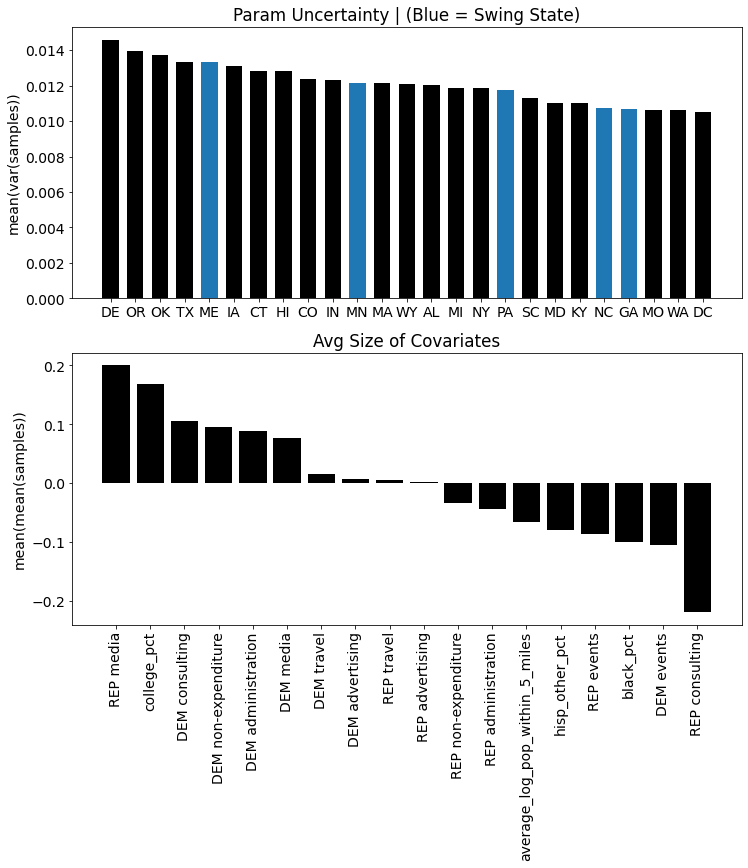

In [ ]:
state_coefs = Induv_Trace['beta']
print("State Level Samples:", state_coefs.shape)

# quick visualization to gaugue both convergence for state level estimates
inspect_samples(state_coefs, states, X.columns, N = 25, M = 18)

- Figure 1: 
  - The first plot displays the states with the highest average variance for the marginal densities for $\beta_i$. These are sorted in order to dispaly the states with the highest level of uncertainty in the parameter estimates. In other words, these states are the hardest to model given the financial and demographic predictors. 
  - Another potential driving factor for parameter uncertainty for each state is voter turnout $N_i$ though I am not 100% certain about this. I make this conclusion because small states such as Delaware, Conneticuit, Hawaii, Maine, etc are all present in the states with the highest variance. 
  - Interestingly, 5 of the swingstates in the 2016 election are present.

<br />

- Figure 2: 
  - The second plot displays the parameter values averaged over all states. The primary observation that supports the validity of the model is that democratic covariates are mainly positive and republican covariates are negative. Recall that $\theta_i$ is the proportion of democratic voters thus republican consultants and their respective strategies naturally have a negative effect! 
  - It is important to realize that for some states the parameter values are $|\beta_{i,j}| > 1$. The displayed values are within such a tight interval [-0.2, 0.2] because many states have covariates which are close to 0. Also remember that our predictors have been standardized! Nonetheless, it is interesting to see which covariates tend to have the largest impact on election outcomes $\theta_i$. 
  - Another observation is that on average external consultants tend to be highly influential. This makes sense because campaign strategy is an effective use of campaign investment, regardless of the state. 



## Multimodal posteriod distribution

Below is a grid of 4 states and 4 covariates and their respective marginal posterior density estimates. Before interpreting meaning of these densities, focus your attention on the second column. This is the distribution of republican advertising across Vermonte, Virgina, Washington, and West Virginia. Clearly this distribution is at least a mixture of two Gaussians. This observation is the primary motivation for my improvement to the original model by incorporating a Gaussian mixture prior. 

Technical details aside, what does this mean in reality? How could it be that we have two 'slopes'?








Note: I dumped the code to make these plots in a .txt file because it it is super ugly and ruins the readability of this notebook.

![kde plots, scale = .4](https://drive.google.com/uc?export=view&id=1-2vlrSNUDAVyrQe-GVgcJqzkaRFv341t)

My guess is that in each state there exist various underlying population groups each with different voting characteristics and the model is picking those out / revealing that underlying structure. For example, in any given state the democratic leaning subpopulation will have a positive response to democratic advertisements while republicans would be less enthusiastic. In a simplified world every marginal posterior would be bimodal to reflect these two underlying groups of people. Within this simplified framework, this is a logical deduction because in any given state there likely exists a rural and urban population with republican and democratcic leanings resepectively. In reality, there exists wide range of voter preferences leading to multiple underlying subpopulations all each a unique response to spending from both parties. If this hypothesis is true, then this specific model is super intersting becayse it can reveal underlying classes of voters in each state! 

<br />


*With a clear understanding of the existing voter classes and how they are distributed across states, a campaign can devise more targeted campaign strategies and optimize expenditures / investments.*
----


# Model 2

The marginal posterior densities estimated with the first model are clearly finite mixtures of gaussians. Now I introduce a Gaussian mixture prior so that we can directly model the latent voter classes / mixture components.

In [ ]:
# Loading in pickled trace from the initial model.
_path = '/content/drive/MyDrive/Data Science/TAMIDS 2021/Competition/single_prior_model.pkl'
with open(_path, 'rb') as input:
    model_dict = pickle.load(input)
    Induv_Model = model_dict['model']
    Induv_Trace = model_dict['trace']

In [ ]:
# fixed parameters
corr_matr = X.corr() + 5*np.eye(num_vars)
prior_mean = np.mean(Induv_Trace['beta_mu'][1000:], axis = 0)

# injecting uncertainty into the covariance
Lambda1 = 50
Lambda2 = 25
Lambda3 = 25

# numer of mixture components
K = 5

In [ ]:
# Specifying Hierarchical Model and performing MCMC
with pm.Model() as Mixture_Model:

  # prior distribution over mixture component means
  beta_mu = pm.MvNormal('beta_mu', mu = prior_mean, cov = Lambda1*np.eye(num_vars), shape = (num_vars,))
  offset = pm.MvNormal('offset', mu = np.zeros(num_vars), cov = Lambda2*np.eye(num_vars), shape = (num_vars,))

  # dirichlet distribution over component weights mixture prior initialization
  weights = pm.Dirichlet('w', a= np.ones(K))
  beta_components = [pm.MvNormal(f'component_{i}', mu = beta_mu+offset, cov = Lambda1*np.eye(num_vars), shape = (num_vars)).distribution for i in range(K)]
  beta_mixture = pm.Mixture('beta_mixture', w = weights, comp_dists = beta_components, shape = ( num_vars))

  # state level effects
  beta = pm.MvNormal('beta', mu = beta_mixture , cov = Lambda3*corr_matr, shape = (num_states, num_vars))

  # binomial-logit regression model
  thetas = pm.math.invlogit(pm.math.sum(X.values*beta, axis = 1))
  likelihood = pm.Binomial("likelihood", observed = y, n = N, p = thetas)
  Mixture_Trace = pm.sample(4500, tune=1000, chains = 1)  

Note that the above model works I just didn't get to a good stopping point so I stopped here.

# To-Do! 

- A lot of stuff still

# References in no particular order

Primary Inspiration: [An Updated Dynamic Bayesian Forecasting Model for the US Presidential Election ](https://hdsr.mitpress.mit.edu/pub/nw1dzd02/release/1)

<br />

**Misc Links**

- https://twiecki.io/blog/2014/03/17/bayesian-glms-3/

- https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

- https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html

- https://m-clark.github.io/bayesian-basics/diagnostics.html

- https://mc-stan.org/docs/2_26/stan-users-guide/clustering-mixture-section.html